#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 11
**CH11A Does Smoking Pose a Health Risk?**

using the share-health dataset

version 1.0 2021-05-05

In [1]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

warnings.filterwarnings("ignore")


In [2]:
path = Path(os.getcwd())

base_dir = path.parent.parent

data_in = os.path.join(str(base_dir), "da_data_repo/share-health/clean/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch11-smoking-health-risk/")
output = os.path.join(str(base_dir), "da_case_studies/ch12-stock-returns-risk/output/")
func = os.path.join(str(base_dir), "da_case_studies/ch00-tech-prep/")


In [3]:
share = pd.read_csv(os.path.join("/workspaces/codespaces-jupyter/data/share_health_p.csv"))
# share = pd.read_csv("https://osf.io/download/snfhe/")

In [4]:
share.head().T

,0,1,2,3,4
mergeid,AT-000327-01,AT-000327-01,AT-000327-02,AT-000327-02,AT-000674-01
wave,1,2,1,2,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria
int_year,2004,2007,2004,2007,2011
int_month,6. June,3. March,6. June,3. March,11. November
female,0. male,0. male,1. female,1. female,1. female
age,51.900001525878906,54.70000076293945,48.900001525878906,51.70000076293945,59.70000076293945
eduyears_mod,-15. no information,-3. implausible value/suspected wrong,3.0,3.0,3.0
sphus,1. Excellent,5. Poor,1. Excellent,2. Very good,3. Good


# Part I – create workfile

In [5]:
share["sphus_num"] = share["sphus"].apply(
    lambda x: float(x[1:3]) if x[0] == "-" else float(x[0])
)
share["sphus_num"].unique()

array([ 1.,  5.,  2.,  3.,  4., 12., 15.])

In [6]:
share["healthy"] = 0
share.loc[(share["sphus_num"] == 1) | (share["sphus_num"] == 2), "healthy"] = 1
share.loc[~((share["sphus_num"] > 0) & (share["sphus_num"] <= 5)), "healthy"] = np.nan

In [7]:
share["healthy"].value_counts()

healthy
0.0    274175
1.0     90176
Name: count, dtype: int64

In [8]:
share = share.dropna(how="any")

In [9]:
share["baseline"] = 0
share.loc[share["wave"] == 4, "baseline"] = 1
share["endline"] = 0
share.loc[share["wave"] == 6, "endline"] = 1

In [10]:
share["baseline"].value_counts()

baseline
0    306531
1     57820
Name: count, dtype: int64

In [11]:
share["endline"].value_counts()

endline
0    296305
1     68046
Name: count, dtype: int64

In [12]:
share["temp"] = np.where(
    share["endline"] == 1, np.where(share["healthy"] == 1, 1, 0), np.nan
)

In [13]:
share["temp"].value_counts()


temp
0.0    51213
1.0    16833
Name: count, dtype: int64

In [14]:
share["stayshealthy"] = share.groupby("mergeid")["temp"].transform(np.nanmax)

In [15]:
share["stayshealthy"].value_counts()

stayshealthy
0.0    187467
1.0     59908
Name: count, dtype: int64

In [16]:
share = share.drop("temp", axis=1)

In [17]:
share["stayshealthy"].unique()

array([nan,  0.,  1.])

In [18]:
# keep if endline health outcome non-missing
share = share.loc[lambda x: (x["stayshealthy"] == 1) | (x["stayshealthy"] == 0)]

In [19]:
share["stayshealthy"].unique()

array([0., 1.])

In [20]:
# keep baseline observations (endline outcome already defined for them)
share = share.loc[lambda x: x["baseline"] == 1]

In [21]:
# keep age 50-60 at baseline
share = share.loc[lambda x: (pd.to_numeric(x["age"], errors="coerce") >= 50) & (pd.to_numeric(x["age"], errors="coerce") <= 60)]

In [22]:
# keep healthy individuals at baseline
share = share.loc[lambda x: x["healthy"] == 1]

In [23]:
# keep those with non-missing observations for smoking at baseline
# and re-define smoking to be 0-1
share["smoking_num"] = share["smoking"].apply(lambda x: float(x[1:3]) if x[0] == "-" else float(x[0]))
share["ever_smoked_num"] = share["ever_smoked"].apply(lambda x: float(x[1:3]) if x[0] == "-" else float(x[0]))


share.loc[lambda x: x["smoking_num"] == 5, "smoking_num"] = 0
share = share.loc[lambda x: (x["smoking_num"] == 0) | (x["smoking_num"] == 1)]

share.loc[lambda x: x["ever_smoked_num"] == 5, "ever_smoked_num"] = 0
share = share.loc[lambda x: (x["ever_smoked_num"] == 0) | (x["ever_smoked_num"] == 1)]

In [24]:
share.T

,15,37,59,159,163,219,387,391,481,525,...,363215,363251,363269,363314,363422,363484,363536,363592,363638,363667
mergeid,AT-001492-02,AT-002136-03,AT-002800-01,AT-009262-02,AT-009376-01,AT-011070-01,AT-018393-01,AT-018393-02,AT-020895-01,AT-022738-01,...,SI-962453-02,SI-966058-01,SI-968901-01,SI-972371-01,SI-978791-01,SI-983385-01,SI-988461-01,SI-991974-01,SI-993306-01,SI-994554-01
wave,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,...,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,...,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia
int_year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
int_month,9. September,8. August,9. September,12. December,9. September,9. September,7. July,7. July,5. May,9. September,...,8. August,8. August,8. August,8. August,8. August,7. July,7. July,8. August,10. October,9. September
female,0. male,1. female,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,...,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,0. male,0. male
age,59.79999923706055,58.20000076293945,60.0,59.29999923706055,53.29999923706055,58.900001525878906,53.29999923706055,52.70000076293945,58.900001525878906,50.400001525878906,...,54.599998474121094,52.79999923706055,51.79999923706055,58.20000076293945,54.20000076293945,55.79999923706055,55.0,53.79999923706055,54.29999923706055,54.599998474121094
eduyears_mod,13.0,14.0,23.0,12.0,3.0,14.0,11.0,12.0,3.0,-3. implausible value/suspected wrong,...,12.0,14.0,16.0,8.0,12.0,16.0,17.0,11.0,4.0,13.0
sphus,2. Very good,1. Excellent,2. Very good,2. Very good,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,2. Very good,...,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,1. Excellent,2. Very good,2. Very good,1. Excellent,2. Very good


In [25]:
share["br015_num"] = share["br015_"].apply(lambda x: float(x[1:3]) if x[0] == "-" else float(x[0]))

share.T

,15,37,59,159,163,219,387,391,481,525,...,363215,363251,363269,363314,363422,363484,363536,363592,363638,363667
mergeid,AT-001492-02,AT-002136-03,AT-002800-01,AT-009262-02,AT-009376-01,AT-011070-01,AT-018393-01,AT-018393-02,AT-020895-01,AT-022738-01,...,SI-962453-02,SI-966058-01,SI-968901-01,SI-972371-01,SI-978791-01,SI-983385-01,SI-988461-01,SI-991974-01,SI-993306-01,SI-994554-01
wave,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,...,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,...,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia
int_year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
int_month,9. September,8. August,9. September,12. December,9. September,9. September,7. July,7. July,5. May,9. September,...,8. August,8. August,8. August,8. August,8. August,7. July,7. July,8. August,10. October,9. September
female,0. male,1. female,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,...,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,0. male,0. male
age,59.79999923706055,58.20000076293945,60.0,59.29999923706055,53.29999923706055,58.900001525878906,53.29999923706055,52.70000076293945,58.900001525878906,50.400001525878906,...,54.599998474121094,52.79999923706055,51.79999923706055,58.20000076293945,54.20000076293945,55.79999923706055,55.0,53.79999923706055,54.29999923706055,54.599998474121094
eduyears_mod,13.0,14.0,23.0,12.0,3.0,14.0,11.0,12.0,3.0,-3. implausible value/suspected wrong,...,12.0,14.0,16.0,8.0,12.0,16.0,17.0,11.0,4.0,13.0
sphus,2. Very good,1. Excellent,2. Very good,2. Very good,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,2. Very good,...,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,1. Excellent,2. Very good,2. Very good,1. Excellent,2. Very good


In [26]:
share["exerc"] = np.where(
    share["br015_num"] == 1,
    1,
    np.where((share["br015_num"] > 0) & (share["br015_num"] != 1), 0, np.nan),
)
share["exerc"].value_counts()

exerc
1.0    1698
0.0    1567
Name: count, dtype: int64

In [27]:
share.T

,15,37,59,159,163,219,387,391,481,525,...,363215,363251,363269,363314,363422,363484,363536,363592,363638,363667
mergeid,AT-001492-02,AT-002136-03,AT-002800-01,AT-009262-02,AT-009376-01,AT-011070-01,AT-018393-01,AT-018393-02,AT-020895-01,AT-022738-01,...,SI-962453-02,SI-966058-01,SI-968901-01,SI-972371-01,SI-978791-01,SI-983385-01,SI-988461-01,SI-991974-01,SI-993306-01,SI-994554-01
wave,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,...,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,...,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia
int_year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
int_month,9. September,8. August,9. September,12. December,9. September,9. September,7. July,7. July,5. May,9. September,...,8. August,8. August,8. August,8. August,8. August,7. July,7. July,8. August,10. October,9. September
female,0. male,1. female,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,...,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,0. male,0. male
age,59.79999923706055,58.20000076293945,60.0,59.29999923706055,53.29999923706055,58.900001525878906,53.29999923706055,52.70000076293945,58.900001525878906,50.400001525878906,...,54.599998474121094,52.79999923706055,51.79999923706055,58.20000076293945,54.20000076293945,55.79999923706055,55.0,53.79999923706055,54.29999923706055,54.599998474121094
eduyears_mod,13.0,14.0,23.0,12.0,3.0,14.0,11.0,12.0,3.0,-3. implausible value/suspected wrong,...,12.0,14.0,16.0,8.0,12.0,16.0,17.0,11.0,4.0,13.0
sphus,2. Very good,1. Excellent,2. Very good,2. Very good,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,2. Very good,...,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,1. Excellent,2. Very good,2. Very good,1. Excellent,2. Very good


In [28]:
share["bmi"].unique()

array(['23.198314666748047', '24.80158805847168', '22.03856658935547',
       ..., '26.173831939697266', '29.270994186401367',
       '25.420015335083008'], shape=(1186,), dtype=object)

In [29]:
share["bmi"] = share["bmi"].apply(lambda x: 0 if str(x)[0] == "-" else float(x))
share["bmi"] = np.where(share["bmi"] < 0, np.nan, share["bmi"])
share["bmi"].describe().round(2)


count    3265.00
mean       24.95
std         5.44
min         0.00
25%        22.60
50%        24.97
75%        27.76
max        45.63
Name: bmi, dtype: float64

In [30]:
share = share.rename(columns={"income_pct_w4": "income10"})

In [31]:
share["married"] = np.where((share["mar_stat"] == 1) | (share["mar_stat"] == 2), 1, 0)

In [32]:
share.T

,15,37,59,159,163,219,387,391,481,525,...,363215,363251,363269,363314,363422,363484,363536,363592,363638,363667
mergeid,AT-001492-02,AT-002136-03,AT-002800-01,AT-009262-02,AT-009376-01,AT-011070-01,AT-018393-01,AT-018393-02,AT-020895-01,AT-022738-01,...,SI-962453-02,SI-966058-01,SI-968901-01,SI-972371-01,SI-978791-01,SI-983385-01,SI-988461-01,SI-991974-01,SI-993306-01,SI-994554-01
wave,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,...,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,...,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia
int_year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
int_month,9. September,8. August,9. September,12. December,9. September,9. September,7. July,7. July,5. May,9. September,...,8. August,8. August,8. August,8. August,8. August,7. July,7. July,8. August,10. October,9. September
female,0. male,1. female,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,...,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,0. male,0. male
age,59.79999923706055,58.20000076293945,60.0,59.29999923706055,53.29999923706055,58.900001525878906,53.29999923706055,52.70000076293945,58.900001525878906,50.400001525878906,...,54.599998474121094,52.79999923706055,51.79999923706055,58.20000076293945,54.20000076293945,55.79999923706055,55.0,53.79999923706055,54.29999923706055,54.599998474121094
eduyears_mod,13.0,14.0,23.0,12.0,3.0,14.0,11.0,12.0,3.0,-3. implausible value/suspected wrong,...,12.0,14.0,16.0,8.0,12.0,16.0,17.0,11.0,4.0,13.0
sphus,2. Very good,1. Excellent,2. Very good,2. Very good,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,2. Very good,...,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,1. Excellent,2. Very good,2. Very good,1. Excellent,2. Very good


In [33]:
share = share[~share["eduyears_mod"].astype(str).str.startswith("-")]

In [34]:
share["eduyears_mod"] = share["eduyears_mod"].astype(float)
share["eduyears"] = np.where(share["eduyears_mod"] < 0, np.nan, share["eduyears_mod"])
share["eduyears"].describe().round(2)

count    3175.00
mean       12.32
std         4.57
min         0.00
25%        10.00
50%        12.00
75%        16.00
max        25.00
Name: eduyears, dtype: float64

In [35]:
share = share.drop("eduyears_mod", axis=1)


In [36]:
share = share.loc[
    lambda x: (x["bmi"].notnull()) & (x["eduyears"].notnull()) & (x["exerc"].notnull())
]


In [37]:
share["female"] = share["female"].apply(lambda x: float(str(x)[0]))
share["age"] = share["age"].astype(float)
share["income10"] = share["income10"].astype(float)
share[["female", "age","income10"]]

,female,age,income10
15,0.0,59.799999,8.0
37,1.0,58.200001,9.0
59,1.0,60.000000,2.0
159,0.0,59.299999,6.0
163,0.0,53.299999,8.0
...,...,...,...
363484,0.0,55.799999,9.0
363536,1.0,55.000000,10.0
363592,1.0,53.799999,7.0
363638,0.0,54.299999,10.0


In [38]:
share.filter(
    [
        "stayshealthy",
        "smoking_num",
        "ever_smoked_num",
        "female",
        "age",
        "income10",
        "eduyears",
        "bmi",
        "exerc",
    ]
).describe().round(2)


,stayshealthy,smoking_num,ever_smoked_num,female,age,income10,eduyears,bmi,exerc
count,3175.00,3175.00,3175.00,3175.00,3175.00,3175.00,3175.00,3175.00,3175.00
mean,0.60,0.22,0.49,0.56,55.19,6.77,12.32,24.94,0.52
std,0.49,0.42,0.50,0.50,2.79,2.75,4.57,5.46,0.50
min,0.00,0.00,0.00,0.00,50.00,1.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,52.80,5.00,10.00,22.60,0.00
50%,1.00,0.00,0.00,1.00,55.30,7.00,12.00,24.97,1.00
75%,1.00,0.00,1.00,1.00,57.50,9.00,16.00,27.76,1.00
max,1.00,1.00,1.00,1.00,60.00,10.00,25.00,45.63,1.00


In [39]:
pd.crosstab(share["country"], share["stayshealthy"])

stayshealthy,0.0,1.0
country,,
11. Austria,125,256
12. Germany,21,25
13. Sweden,25,55
15. Spain,89,101
16. Italy,120,86
17. France,136,170
18. Denmark,73,325
20. Switzerland,134,316
23. Belgium,176,268


In [40]:
share.reset_index(drop=True).to_csv("ch11_share.csv")


#  2. PART - SIMPLE LPM MODELS

In [41]:
share = pd.read_csv("ch11_share.csv", index_col=0)

In [42]:
share.head()

,mergeid,wave,country,country_mod,int_year,int_month,female,age,sphus,br015_,...,healthy,baseline,endline,stayshealthy,smoking_num,ever_smoked_num,br015_num,exerc,married,eduyears
0,AT-001492-02,4,11. Austria,40. Austria,2011,9. September,0.0,59.799999,2. Very good,3. One to three times a month,...,1.0,1,0,1.0,1.0,1.0,3.0,0.0,0,13.0
1,AT-002136-03,4,11. Austria,40. Austria,2011,8. August,1.0,58.200001,1. Excellent,2. Once a week,...,1.0,1,0,1.0,1.0,1.0,2.0,0.0,0,14.0
2,AT-002800-01,4,11. Austria,40. Austria,2011,9. September,1.0,60.000000,2. Very good,"4. Hardly ever, or never",...,1.0,1,0,1.0,0.0,0.0,4.0,0.0,0,23.0
3,AT-009262-02,4,11. Austria,40. Austria,2011,12. December,0.0,59.299999,2. Very good,1. More than once a week,...,1.0,1,0,0.0,0.0,1.0,1.0,1.0,0,12.0
4,AT-009376-01,4,11. Austria,40. Austria,2011,9. September,0.0,53.299999,2. Very good,1. More than once a week,...,1.0,1,0,0.0,1.0,1.0,1.0,1.0,0,3.0


In [43]:
lpm1 = smf.ols("stayshealthy ~ smoking_num", data=share).fit(cov_type="HC1")

In [44]:
lpm2 = smf.ols("stayshealthy ~ smoking_num + ever_smoked_num", data=share).fit(covtype="HC1")

### Table 11.1 Probability of staying healthy

In [45]:
results = pd.DataFrame({
    "Model 1 Coef": lpm1.params,
    "Model 1 P-value": lpm1.pvalues,
    "Model 2 Coef": lpm2.params,
    "Model 2 P-value": lpm2.pvalues,
})
print(results)


                 Model 1 Coef  Model 1 P-value  Model 2 Coef  Model 2 P-value
Intercept            0.618720         0.000000      0.612885         0.000000
ever_smoked_num           NaN              NaN      0.016531         0.412873
smoking_num         -0.071336         0.000733     -0.081496         0.000788


In [46]:
lpm1.summary(),


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:           stayshealthy   R-squared:                       0.004
 Model:                            OLS   Adj. R-squared:                  0.003
 Method:                 Least Squares   F-statistic:                     11.40
 Date:                Tue, 15 Jul 2025   Prob (F-statistic):           0.000742
 Time:                        01:20:11   Log-Likelihood:                -2229.9
 No. Observations:                3175   AIC:                             4464.
 Df Residuals:                    3173   BIC:                             4476.
 Df Model:                           1                                         
 Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------

In [47]:
lpm2.summary(),


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:           stayshealthy   R-squared:                       0.004
 Model:                            OLS   Adj. R-squared:                  0.003
 Method:                 Least Squares   F-statistic:                     6.193
 Date:                Tue, 15 Jul 2025   Prob (F-statistic):            0.00207
 Time:                        01:20:11   Log-Likelihood:                -2229.6
 No. Observations:                3175   AIC:                             4465.
 Df Residuals:                    3172   BIC:                             4483.
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------------------------------------------------

In [48]:
stargazer = Stargazer([lpm1, lpm2])
stargazer.covariate_order(["smoking_num", "ever_smoked_num", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


In [49]:
ci_95 = lpm1.conf_int()
print("95% Confidence Intervals:")
print(ci_95)

95% Confidence Intervals:
                    0         1
Intercept    0.599551  0.637888
smoking_num -0.112742 -0.029931


In [50]:
share["pred1"] = lpm1.predict()
pd.crosstab(index=share["pred1"], columns=share["smoking"])


smoking,1. Yes,5. No
pred1,,
0.547383,707,0
0.618720,0,2468


In [51]:
pd.crosstab(index=share["stayshealthy"], columns=share["smoking"])


smoking,1. Yes,5. No
stayshealthy,,
0.0,320,941
1.0,387,1527


In [52]:
share["weight"] = share.groupby(["smoking", "stayshealthy"])["smoking"].transform(len)
share["weight_2"] = share["weight"] / 1000


### Figure 11.1 Staying healthy and smoking – scatterplot and regression line

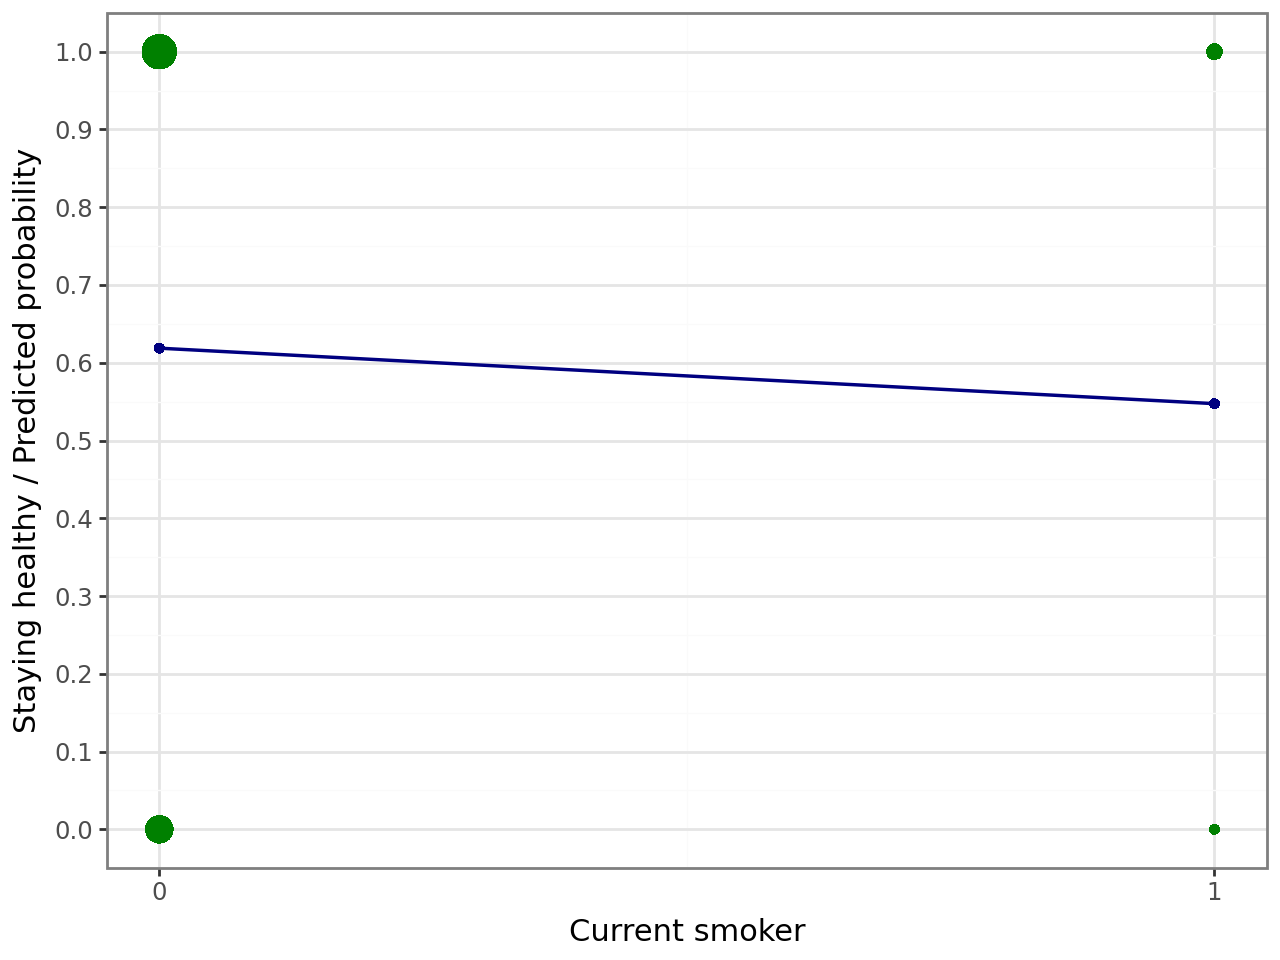

In [53]:
g1 = (
    ggplot(data=share)
    + geom_point(aes(x="smoking_num", y="pred1"), size=1, color="navy")
    + geom_line(aes(x="smoking_num", y="pred1"), colour="navy", size=0.7)
    + geom_point(
        aes(x="smoking_num", y="stayshealthy", size="weight_2"),
        fill="green",
        color="green",
        alpha=0.8,
        show_legend=False,
    )
    + labs(x="Current smoker", y="Staying healthy / Predicted probability")
    + coord_cartesian(xlim=[0, 1], ylim=[0, 1])
    + scale_y_continuous(limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + scale_x_continuous(limits=[0, 1], breaks=np.arange(0, 2, 1))
    + theme_bw()
)
g1

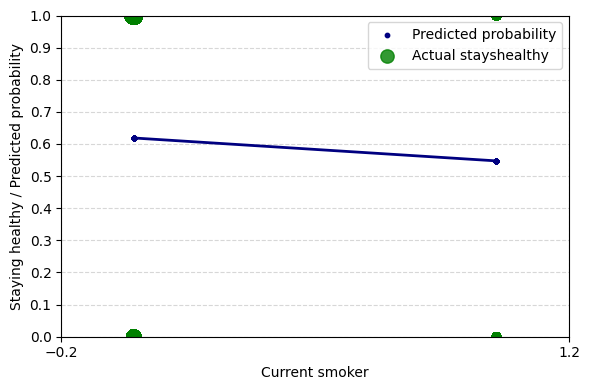

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot for predicted probability
ax.scatter(share["smoking_num"], share["pred1"], s=10, color="navy", label="Predicted probability")

# Line plot for predicted probability
smoking_vals = np.sort(share["smoking_num"].unique())
pred_means = [share.loc[share["smoking_num"] == val, "pred1"].mean() for val in smoking_vals]
ax.plot(smoking_vals, pred_means, color="navy", linewidth=2)

# Scatter plot for actual stayshealthy, sized by weight_2
ax.scatter(
    share["smoking_num"],
    share["stayshealthy"],
    s=share["weight_2"] * 100,  # scale marker size
    color="green",
    alpha=0.8,
    label="Actual stayshealthy"
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Current smoker")
ax.set_ylabel("Staying healthy / Predicted probability")
ax.set_xticks([-0.2, 1.2])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [55]:
share["weight"] = (
    share.groupby(["eduyears", "stayshealthy"])["smoking"].transform(len) / 100
)


### Figure 11.2 Education, income, and the probability of staying healthy – non-parametric regressions

(a) Staying healthy and years of education

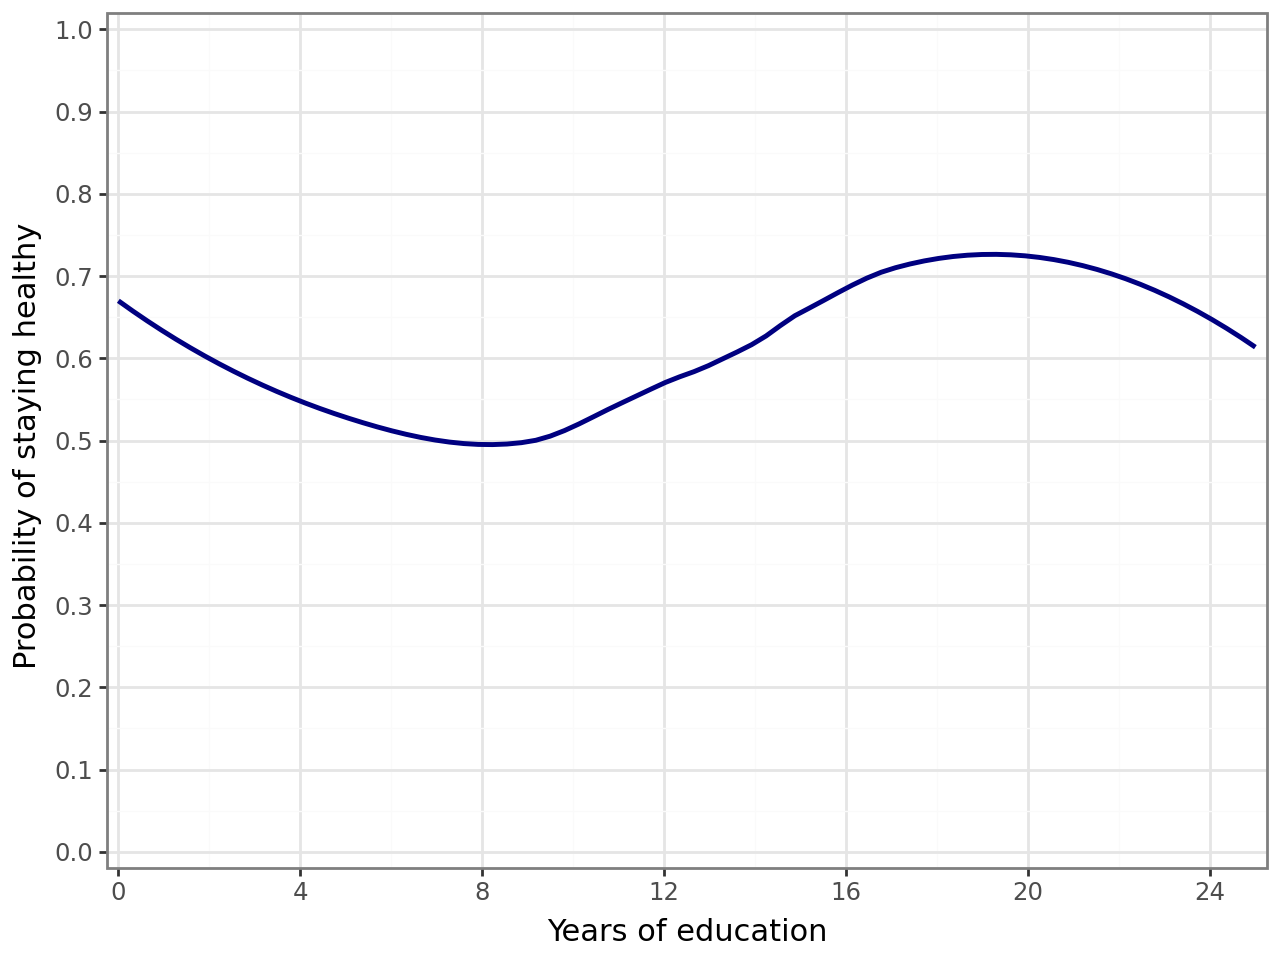

In [56]:
g2 = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="eduyears", y="stayshealthy"), method="loess", se=False, color="navy"
    )
    + labs(x="Years of education", y="Probability of staying healthy ")
    # + coord_cartesian(xlim = [0, 1], ylim=[0,1])
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 25], breaks=np.arange(0, 25, 4))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)
g2


(b) Staying healthy and income group

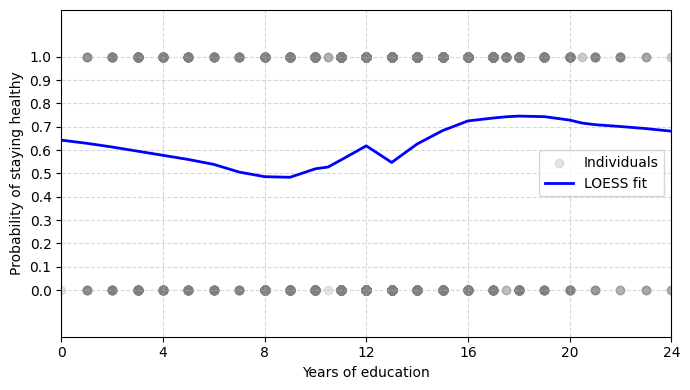

In [57]:
from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

# Scatter plot of stayshealthy vs eduyears
ax.scatter(share["eduyears"], share["stayshealthy"], alpha=0.2, color="gray", label="Individuals")

# Loess smoothing (non-parametric regression)
loess_smoothed = lowess(share["stayshealthy"], share["eduyears"], frac=0.3)
ax.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], color="blue", linewidth=2, label="LOESS fit")

ax.set_xlabel("Years of education")
ax.set_ylabel("Probability of staying healthy")
ax.set_xlim(0, 24)
plt.ylim(-0.2, 1.2)
ax.set_xticks(range(0, 25, 4))
ax.set_yticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


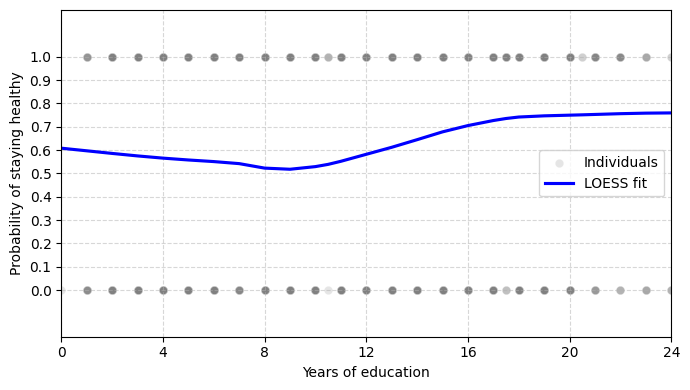

In [58]:
import seaborn as sns

plt.figure(figsize=(7, 4))
sns.scatterplot(x="eduyears", y="stayshealthy", data=share, alpha=0.2, color="gray", label="Individuals")
sns.regplot(x="eduyears", y="stayshealthy", data=share, lowess=True, scatter=False, color="blue", label="LOESS fit")

plt.xlabel("Years of education")
plt.ylabel("Probability of staying healthy")
plt.xlim(0, 24)
plt.ylim(-0.2, 1.2)
plt.xticks(range(0, 25, 4))
plt.yticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


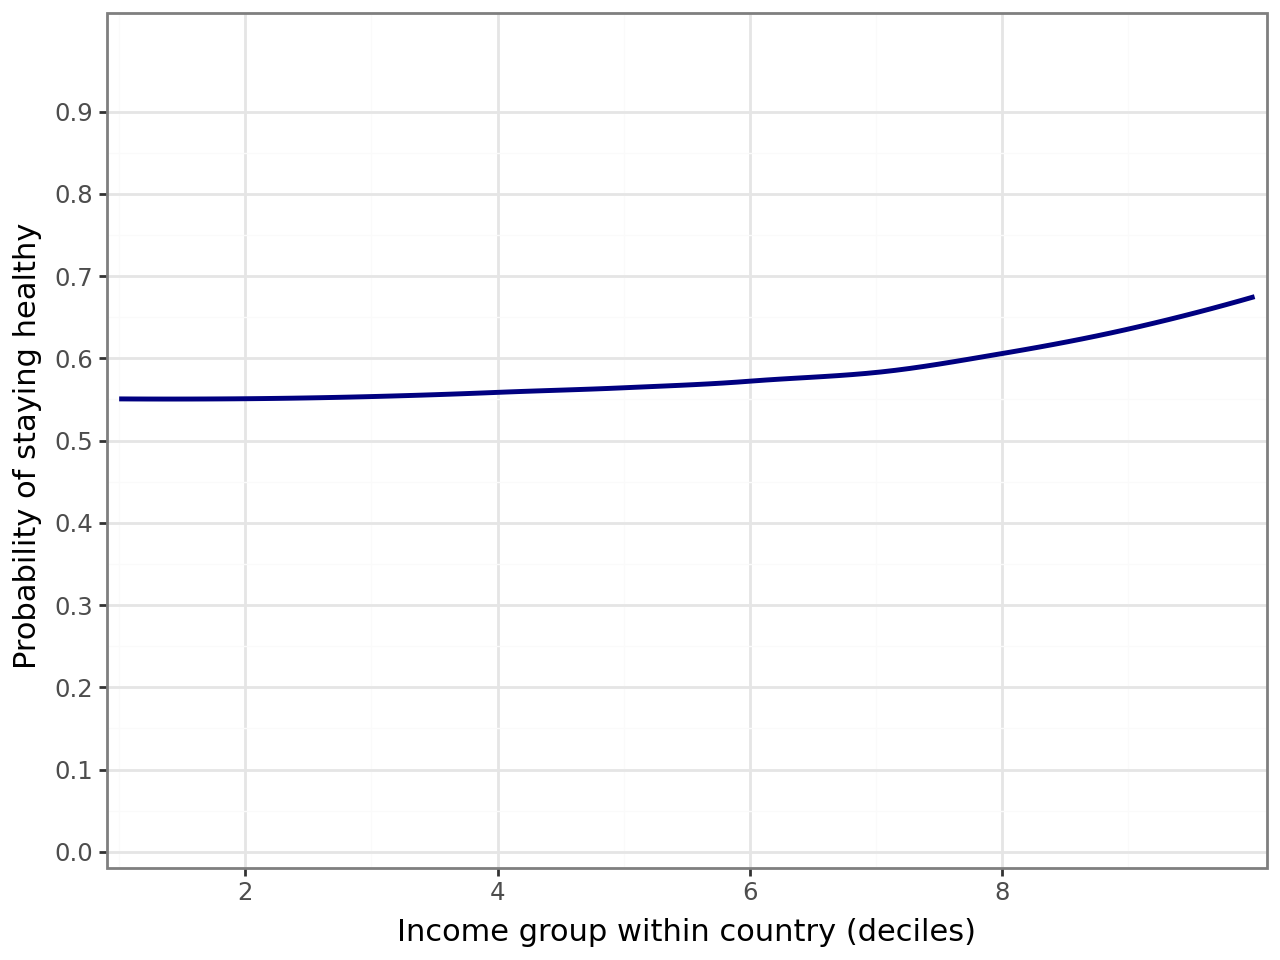

In [59]:
g2b = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="income10", y="stayshealthy"), method="loess", se=False, color="navy"
    )
    + labs(
        x="Income group within country (deciles)", y="Probability of staying healthy "
    )
    + scale_x_continuous(expand=[0.01, 0.01], limits=[1, 10], breaks=np.arange(0, 10, 2))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1, 0.1))
    + theme_bw()
)
g2b


Not in the book

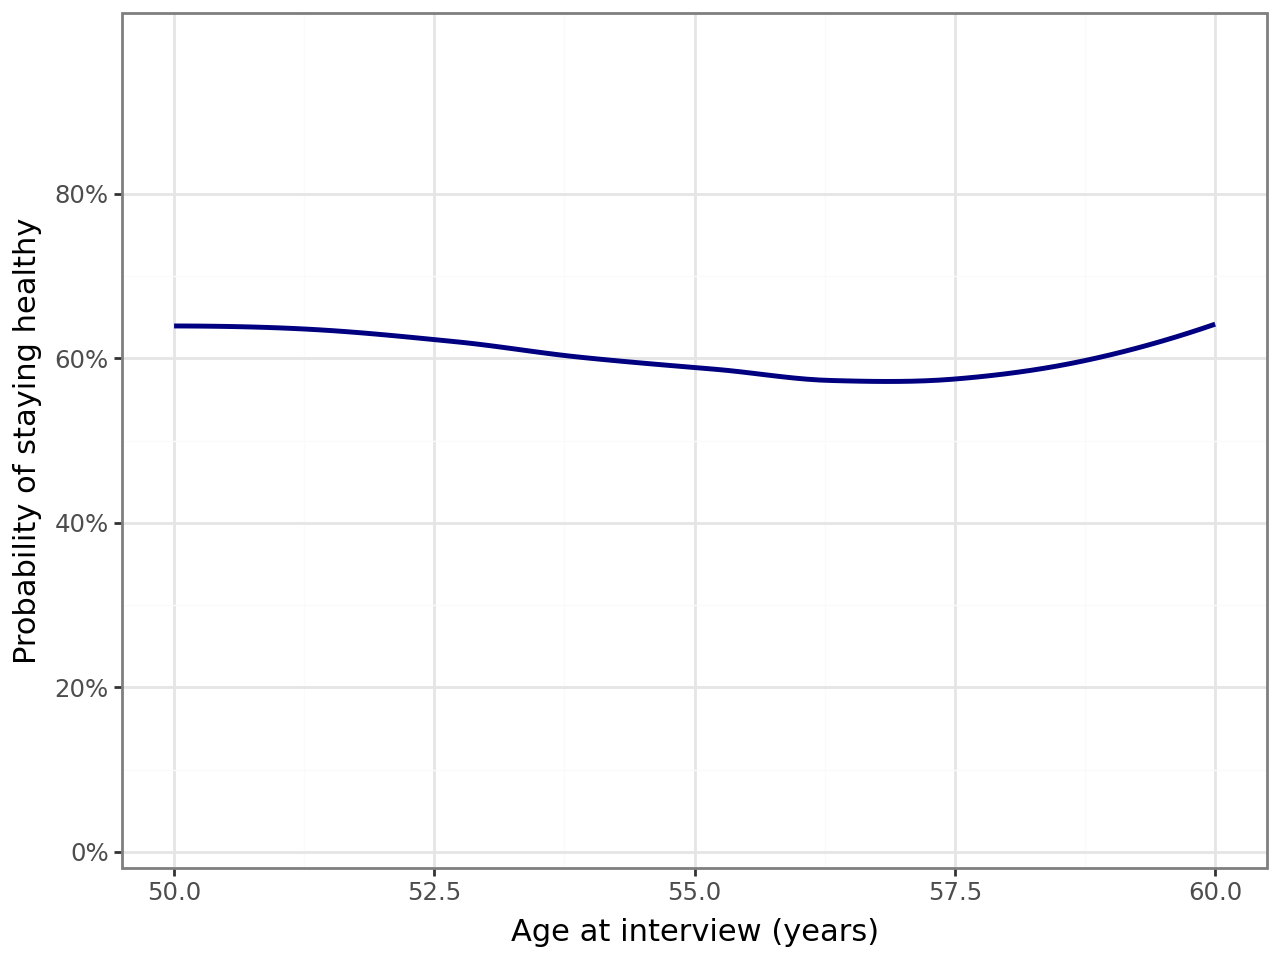

In [60]:
g2c = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="age", y="stayshealthy"), method="loess", se=False, color="navy"
    )
    + scale_y_continuous(
        expand=[0.01, 0.01],
        limits=[0, 1],
        breaks=np.arange(0, 1, 0.2),
        labels=percent_format(),
    )
    + labs(x="Age at interview (years)", y="Probability of staying healthy")
    + theme_bw()
)
g2c


Not in the book

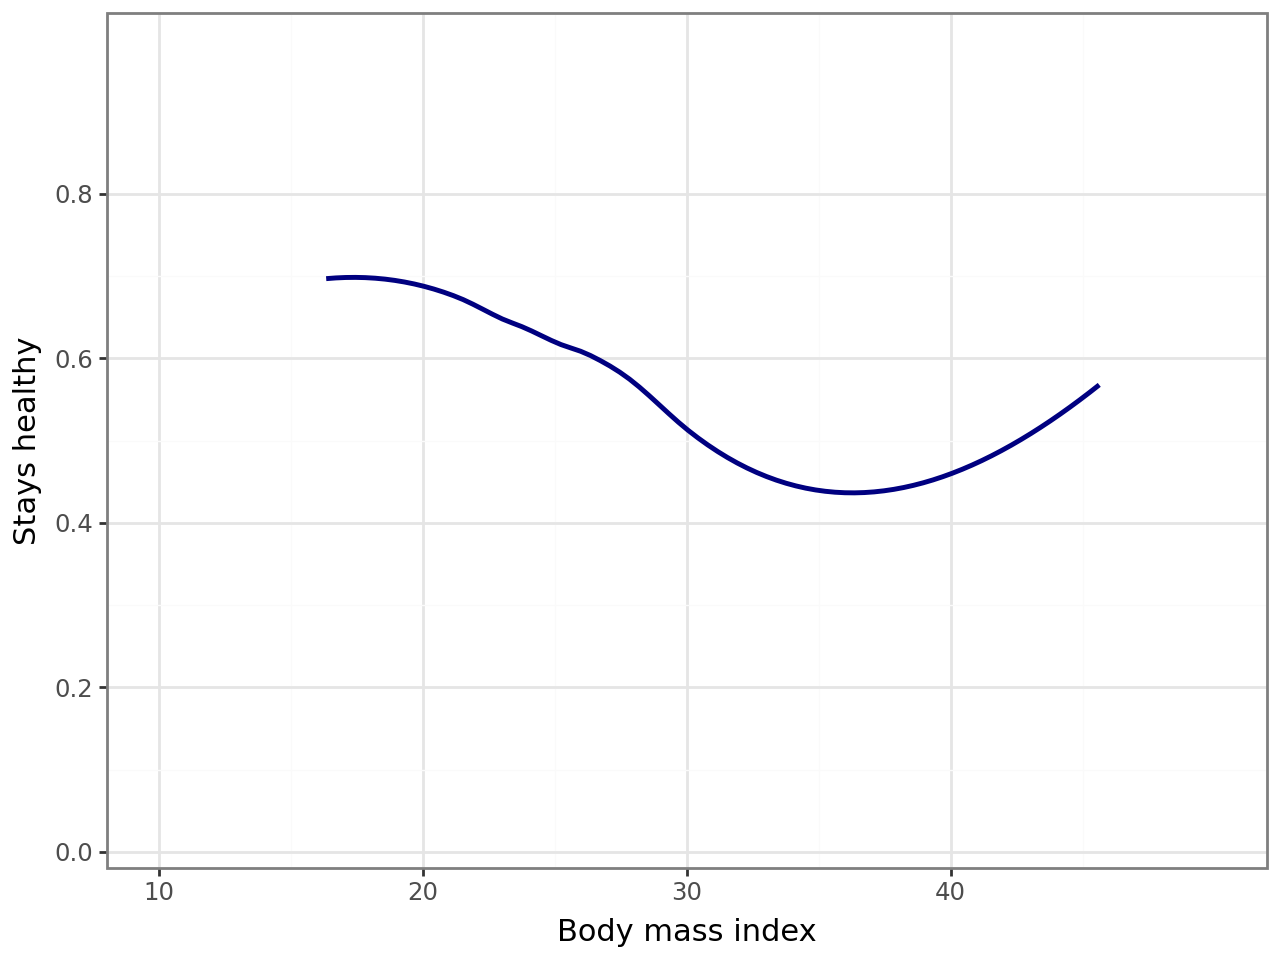

In [61]:
g2d = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="bmi", y="stayshealthy"), method="loess", se=False, color="navy"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1, 0.2))
    + scale_x_continuous(limits=[10, 50], breaks=np.arange(10, 50, 10))
    + labs(x="Body mass index", y="Stays healthy")
    + theme_bw()
)
g2d


# 3. PART - PROBABILITY MODELS (LPM, LOGIT, PROBIT) & PREDICTION

In [62]:
share["country"] = share["country"].astype("category")


In [63]:
# Create piesewise splines

knot1 = 8
knot2 = 18
share["lspline_0"] = share["eduyears"]
share["lspline_1"] = (share["eduyears"] - knot1).clip(lower=0) - (share["eduyears"] - knot2).clip(lower=0)
share["lspline_2"] = (share["eduyears"] - knot2).clip(lower=0)


knot3 = 35
share["lspline_4"] = share["bmi"]
share["lspline_5"] = (share["bmi"] - knot3).clip(lower=0)



In [64]:
share.T

,0,1,2,3,4,5,6,7,8,9,...,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174
mergeid,AT-001492-02,AT-002136-03,AT-002800-01,AT-009262-02,AT-009376-01,AT-011070-01,AT-018393-01,AT-018393-02,AT-020895-01,AT-022738-03,...,SI-962453-02,SI-966058-01,SI-968901-01,SI-972371-01,SI-978791-01,SI-983385-01,SI-988461-01,SI-991974-01,SI-993306-01,SI-994554-01
wave,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,...,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,...,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia
int_year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
int_month,9. September,8. August,9. September,12. December,9. September,9. September,7. July,7. July,5. May,9. September,...,8. August,8. August,8. August,8. August,8. August,7. July,7. July,8. August,10. October,9. September
female,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
age,59.799999,58.200001,60.0,59.299999,53.299999,58.900002,53.299999,52.700001,58.900002,53.0,...,54.599998,52.799999,51.799999,58.200001,54.200001,55.799999,55.0,53.799999,54.299999,54.599998
sphus,2. Very good,1. Excellent,2. Very good,2. Very good,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,2. Very good,...,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,1. Excellent,2. Very good,2. Very good,1. Excellent,2. Very good
br015_,3. One to three times a month,2. Once a week,"4. Hardly ever, or never",1. More than once a week,1. More than once a week,1. More than once a week,3. One to three times a month,2. Once a week,1. More than once a week,1. More than once a week,...,1. More than once a week,1. More than once a week,1. More than once a week,2. Once a week,3. One to three times a month,"4. Hardly ever, or never","4. Hardly ever, or never",1. More than once a week,1. More than once a week,1. More than once a week


In [65]:
lpm3 = smf.ols(
    "stayshealthy ~ smoking_num + ever_smoked_num + female + age + lspline_0 + lspline_1 + lspline_2 + income10 + lspline_4 + lspline_5 + exerc + country",
    share,
).fit(covtype="HC1")


### Table 11.2 Smoking and the probability of staying healthy – rich LPM

In [66]:
stargazer = Stargazer([lpm3])
stargazer.covariate_order(
    [
        "smoking_num",
        "ever_smoked_num",
        "female",
        "age",
        "lspline_0",
        "lspline_1",
        "lspline_2",
        "income10",
        "lspline_4",
        "lspline_5",
        "exerc",
    ]
)
stargazer.rename_covariates({"Intercept": "Constant", "lspline_0": "Years of Education (if < 8)", "lspline_1": "Years of Education (if 8-12)", 
                             "lspline_2": "Years of Education (if > 12)", "lspline_4": "BMI (if < 35)", "lspline_5":  "BMI (if >= 35)"})
stargazer.add_line("Country indicators", ["Yes"])
stargazer


In [67]:
lpm3.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stayshealthy   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     14.45
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           1.33e-55
Time:                        01:20:14   Log-Likelihood:                -2069.9
No. Observations:                3175   AIC:                             4190.
Df Residuals:                    3150   BIC:                             4341.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.8059      0.183      4.397      0.000       0.446       1.165
country[T.12. Germany]           -0.1962      0.074     -2.655      0.008      -0.341      -0.051
country[T.13. Sweden]            -0.0274      0.059     -0.466      0.641      -0.142       0.088
country[T.15. Spain]             -0.1469      0.042     -3.524      0.000      -0.229      -0.065
country[T.16. Italy]             -0.2385      0.041     -5.862      0.000      -0.318      -0.159
country[T.17. France]            -0.1546      0.037     -4.224      0.000      -0.226      -0.083
country[T.18. Denmark]            0.0770      0.035      2.201      0.028       0.008       0.146
country[T.20. Switzerland]        0.0315      0.033      0.953      0.341      -0.033       0.096
country[T.23. Belgium]           -0.1167      0.034     -3.471      0.001      -0.183      -0.051
country[T.28. Czech Republic]    -0.1608      0.038     -4.189      0.000      -0.236      -0.086
country[T.29. Poland]            -0.3215      0.084     -3.815      0.000      -0.487      -0.156
country[T.33. Portugal]          -0.3992      0.060     -6.667      0.000      -0.517      -0.282
country[T.34. Slovenia]          -0.2056      0.045     -4.586      0.000      -0.294      -0.118
country[T.35. Estonia]           -0.3128      0.046     -6.802      0.000      -0.403      -0.223
smoking_num                      -0.0573      0.023     -2.442      0.015      -0.103      -0.011
ever_smoked_num                   0.0149      0.020      0.766      0.444      -0.023       0.053
female                            0.0514      0.017      2.984      0.003       0.018       0.085
age                              -0.0033      0.003     -1.070      0.285      -0.009       0.003
lspline_0                        -0.0029      0.007     -0.405      0.685      -0.017       0.011
lspline_1                         0.0222      0.009      2.448      0.014       0.004       0.040
lspline_2                        -0.0073      0.013     -0.566      0.571      -0.033       0.018
income10                          0.0080      0.003      2.575      0.010       0.002       0.014
lspline_4                        -0.0041      0.002     -2.518      0.012      -0.007      -0.001
lspline_5                        -0.0038      0.016     -0.236      0.813      -0.035       0.028
exerc                             0.0589      0.017      3.502      0.000       0.026       0.092
==============================================================================
Omnibus:                    22348.259   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.854
Skew:                          -0.365   Prob(JB):                     5.34e-78
Kurtosis:              

In [68]:
share["pred_lpm"] = lpm3.predict()


In [69]:
share["pred_lpm"].describe().round(4)


count    3175.0000
mean        0.6028
std         0.1541
min         0.0905
25%         0.5002
50%         0.6079
75%         0.7054
max         0.9857
Name: pred_lpm, dtype: float64

### Figure 11.3 Histogram of the predicted probabilities

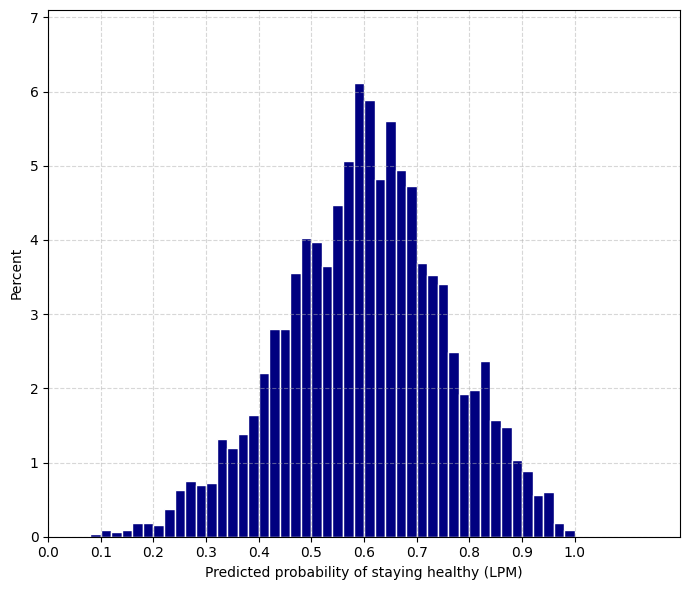

In [84]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,6))
counts, bins, patches = ax.hist(
    share["pred_lpm"],
    bins=int((1-0)/0.02),
    range=(0, 1),
    color="navy",
    edgecolor="white"
)

# Convert counts to percent
percent = counts / counts.sum() * 100
ax.cla()  # Clear the current axes

ax.bar(bins[:-1], percent, width=(bins[1]-bins[0]), color="navy", edgecolor="white", align="edge")

ax.set_xlabel("Predicted probability of staying healthy (LPM)")
ax.set_ylabel("Percent")
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 7.1)
ax.set_yticks([round(x, 2) for x in np.arange(0, 7.1, 1)])
ax.set_xticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [85]:
share['pred_lpm'].describe().round(4)

count    3175.0000
mean        0.6028
std         0.1541
min         0.0905
25%         0.5002
50%         0.6079
75%         0.7054
max         0.9857
Name: pred_lpm, dtype: float64

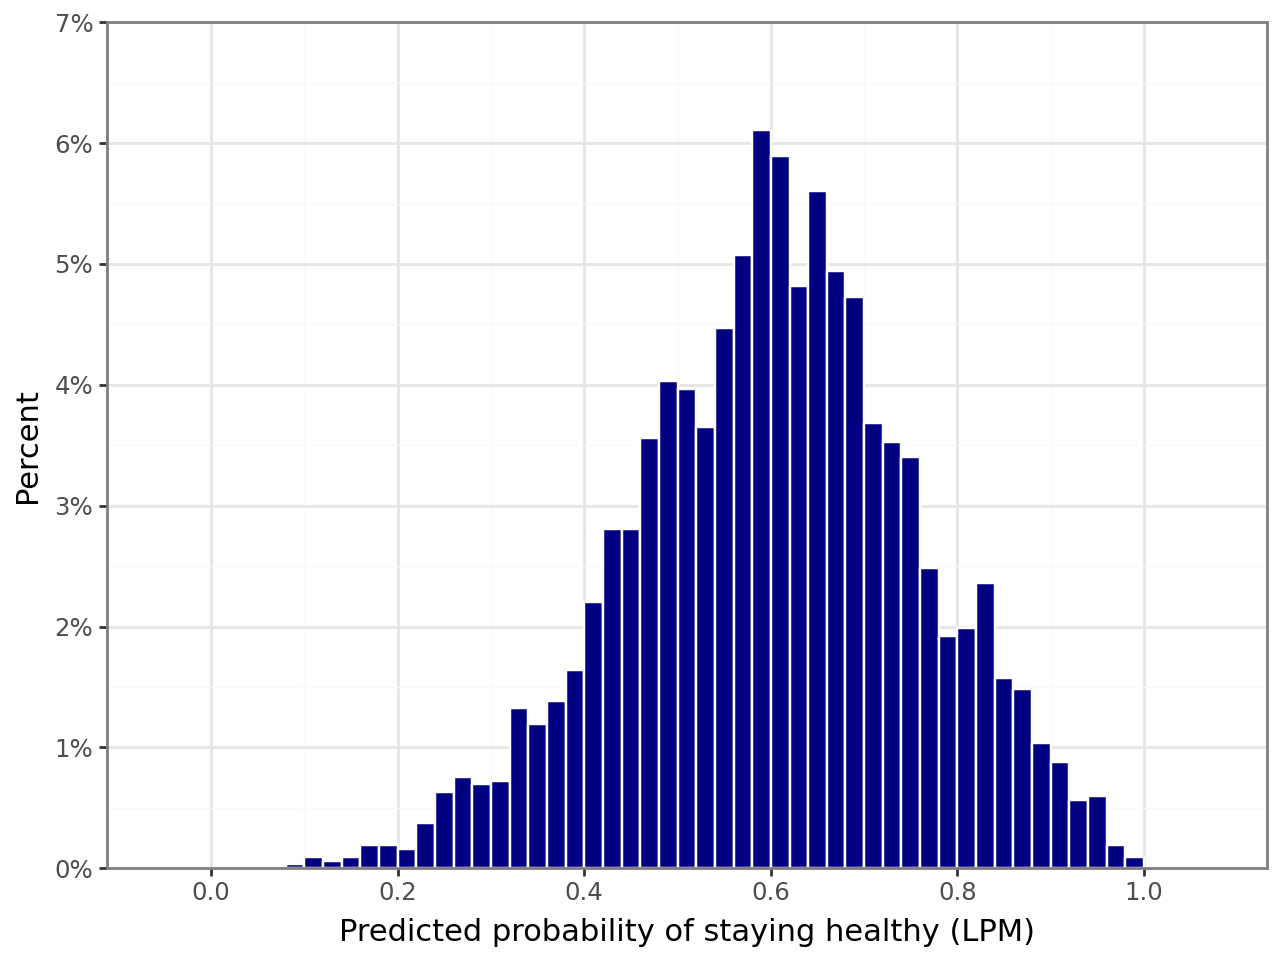

In [76]:
g3 = (
    ggplot(share, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill="navy",
        closed="right",
    )
    + labs(x="Predicted probability of staying healthy (LPM)", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=np.arange(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1.02], breaks=np.arange(0, 1.02, 0.2))
    + theme_bw()
)
g3


In [72]:
cuts = 100
share["q100_pred_lpm"] = pd.qcut(share["pred_lpm"], q=cuts, labels=range(1, cuts + 1))


In [73]:
share.loc[
    share["q100_pred_lpm"] == 1,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

# Bottom 1%


,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0
mean,0.4,55.2,6.5,4.5,27.0,0.2
std,0.5,2.7,2.7,3.1,4.1,0.4
min,0.0,50.4,3.0,1.0,20.5,0.0
25%,0.0,53.2,4.0,1.8,23.7,0.0
50%,0.0,55.2,6.0,4.0,26.1,0.0
75%,1.0,57.4,8.2,7.0,30.1,0.0
max,1.0,59.4,12.0,10.0,36.3,1.0


In [74]:
share.loc[
    share["q100_pred_lpm"] == 100,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

# Top 1%


,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0
mean,1.0,53.3,17.6,8.8,20.0,0.9
std,0.2,2.4,1.5,1.9,6.8,0.2
min,0.0,50.6,13.0,3.0,0.0,0.0
25%,1.0,51.5,16.8,8.8,20.0,1.0
50%,1.0,52.4,17.8,10.0,21.8,1.0
75%,1.0,54.3,18.0,10.0,23.3,1.0
max,1.0,60.0,21.0,10.0,26.4,1.0


# 4. PART - LOGIT VS. PROBIT MODELS

In [86]:
y, X = dmatrices(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline_0 + lspline_1 + lspline_2 + income10 + lspline_4 + lspline_5 + exerc + country",
    share,
)

logit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
logit = logit.fit()


In [87]:
logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3175
Model:                            GLM   Df Residuals:                     3150
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1968.0
Date:                Tue, 15 Jul 2025   Deviance:                       3936.0
Time:                        01:34:13   Pearson chi2:                 3.18e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09878
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.1756      0.844      1.393      0.164      -0.478       2.830
smoking[T.5. No]                  0.2688      0.108      2.493      0.013       0.057       0.480
ever_smoked[T.5. No]             -0.0770      0.091     -0.847      0.397      -0.255       0.101
country[T.12. Germany]           -0.8801      0.326     -2.704      0.007      -1.518      -0.242
country[T.13. Sweden]            -0.1356      0.275     -0.494      0.621      -0.674       0.403
country[T.15. Spain]             -0.6439      0.187     -3.443      0.001      -1.010      -0.277
country[T.16. Italy]             -1.0166      0.183     -5.540      0.000      -1.376      -0.657
country[T.17. France]            -0.6915      0.166     -4.165      0.000      -1.017      -0.366
country[T.18. Denmark]            0.4784      0.178      2.680      0.007       0.129       0.828
country[T.20. Switzerland]        0.1541      0.156      0.989      0.323      -0.151       0.460
country[T.23. Belgium]           -0.5368      0.154     -3.479      0.001      -0.839      -0.234
country[T.28. Czech Republic]    -0.7181      0.173     -4.142      0.000      -1.058      -0.378
country[T.29. Poland]            -1.3872      0.392     -3.537      0.000      -2.156      -0.619
country[T.33. Portugal]          -1.7674      0.295     -6.001      0.000      -2.345      -1.190
country[T.34. Slovenia]          -0.8986      0.201     -4.480      0.000      -1.292      -0.505
country[T.35. Estonia]           -1.3569      0.208     -6.515      0.000      -1.765      -0.949
female                            0.2428      0.080      3.049      0.002       0.087       0.399
age                              -0.0154      0.014     -1.091      0.275      -0.043       0.012
lspline_0                        -0.0112      0.032     -0.345      0.730      -0.075       0.052
lspline_1                         0.1001      0.041      2.424      0.015       0.019       0.181
lspline_2                        -0.0354      0.060     -0.586      0.558      -0.154       0.083
income10                          0.0362      0.014      2.535      0.011       0.008       0.064
lspline_4                        -0.0193      0.008     -2.513      0.012      -0.034      -0.004
lspline_5                        -0.0118      0.072     -0.164      0.870      -0.152       0.129
exerc                             0.2776      0.078      3.568      0.000       0.125       0.430
=================================================================================================
"""

In [88]:
share["pred_logit"] = logit.predict()

In [89]:
share["pred_logit"].describe()

count    3175.000000
mean        0.602835
std         0.154648
min         0.136611
25%         0.497812
50%         0.612834
75%         0.712762
max         0.911030
Name: pred_logit, dtype: float64

In [90]:
logit = sm.Logit(y, X)

In [91]:
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.619841
         Iterations 5


In [92]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3175
Model:                          Logit   Df Residuals:                     3150
Method:                           MLE   Df Model:                           24
Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                 0.07741
Time:                        01:35:10   Log-Likelihood:                -1968.0
converged:                       True   LL-Null:                       -2133.1
Covariance Type:            nonrobust   LLR p-value:                 1.307e-55
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.1756      0.844      1.393      0.164      -0.478       2.830
smoking[T.5. No]                  0.2688      0.108      2.493      0.013       0.057       0.480
ever_smoked[T.5. No]             -0.0770      0.091     -0.847      0.397      -0.255       0.101
country[T.12. Germany]           -0.8801      0.326     -2.704      0.007      -1.518      -0.242
country[T.13. Sweden]            -0.1356      0.275     -0.494      0.621      -0.674       0.403
country[T.15. Spain]             -0.6439      0.187     -3.443      0.001      -1.010      -0.277
country[T.16. Italy]             -1.0166      0.183     -5.540      0.000      -1.376      -0.657
country[T.17. France]            -0.6915      0.166     -4.165      0.000      -1.017      -0.366
country[T.18. Denmark]            0.4784      0.178      2.680      0.007       0.129       0.828
country[T.20. Switzerland]        0.1541      0.156      0.989      0.323      -0.151       0.460
country[T.23. Belgium]           -0.5368      0.154     -3.479      0.001      -0.839      -0.234
country[T.28. Czech Republic]    -0.7181      0.173     -4.142      0.000      -1.058      -0.378
country[T.29. Poland]            -1.3872      0.392     -3.537      0.000      -2.156      -0.619
country[T.33. Portugal]          -1.7674      0.295     -6.001      0.000      -2.345      -1.190
country[T.34. Slovenia]          -0.8986      0.201     -4.480      0.000      -1.292      -0.505
country[T.35. Estonia]           -1.3569      0.208     -6.515      0.000      -1.765      -0.949
female                            0.2428      0.080      3.049      0.002       0.087       0.399
age                              -0.0154      0.014     -1.091      0.275      -0.043       0.012
lspline_0                        -0.0112      0.032     -0.345      0.730      -0.075       0.052
lspline_1                         0.1001      0.041      2.424      0.015       0.019       0.181
lspline_2                        -0.0354      0.060     -0.586      0.558      -0.154       0.083
income10                          0.0362      0.014      2.535      0.011       0.008       0.064
lspline_4                        -0.0193      0.008     -2.513      0.012      -0.034      -0.004
lspline_5                        -0.0118      0.072     -0.164      0.870      -0.152       0.129
exerc                             0.2776      0.078      3.568      0.000       0.125       0.430
=================================================================================================
"""

In [ ]:
logit_margef_results = logit_result.get_margeff()


In [ ]:
logit_margef_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2106      0.070     -2.993      0.003      -0.349      -0.073
country[T.13]                    -0.0423      0.059     -0.714      0.475      -0.158       0.074
country[T.15]                    -0.1406      0.041     -3.406      0.001      -0.221      -0.060
country[T.16]                    -0.2399      0.039     -6.191      0.000      -0.316      -0.164
country[T.17]                    -0.1682      0.036     -4.701      0.000      -0.238      -0.098
country[T.18]                     0.0934      0.039      2.417      0.016       0.018       0.169
country[T.20]                     0.0146      0.034      0.427      0.670      -0.052       0.081
country[T.23]                    -0.1229      0.033     -3.678      0.000      -0.188      -0.057
country[T.28]                    -0.1618      0.037     -4.345      0.000      -0.235      -0.089
country[T.29]                    -0.3152      0.084     -3.751      0.000      -0.480      -0.150
country[T.33]                    -0.3382      0.063     -5.332      0.000      -0.463      -0.214
country[T.34]                    -0.1972      0.043     -4.538      0.000      -0.282      -0.112
country[T.35]                    -0.2901      0.044     -6.582      0.000      -0.376      -0.204
smoking                          -0.0609      0.023     -2.611      0.009      -0.107      -0.015
ever_smoked                       0.0168      0.020      0.849      0.396      -0.022       0.055
female                            0.0345      0.018      1.968      0.049       0.000       0.069
age                              -0.0026      0.003     -0.859      0.390      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0006      0.007     -0.090      0.928      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0170      0.003      5.097      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0098      0.012     -0.825      0.409      -0.033       0.013
income10                          0.0076      0.003      2.461      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0123      0.002     -5.109      0.000      -0.017      -0.008
lspline(bmi, [35])[1]             0.0067      0.015      0.439      0.661      -0.023       0.036
exerc                             0.0546      0.017      3.248      0.001       0.022       0.088
=================================================================================================
"""

In [ ]:
probit = sm.Probit(y, X)


In [ ]:
probit_result = probit.fit()


Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [ ]:
probit_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08018
Time:                        15:48:15   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [ ]:
share["pred_probit"] = probit_result.predict()


In [ ]:
share["pred_probit"].describe()


count    3109.000000
mean        0.604763
std         0.156611
min         0.103114
25%         0.498824
50%         0.612903
75%         0.720459
max         0.930006
Name: pred_probit, dtype: float64

In [ ]:
probit_margef_results = probit_result.get_margeff()


In [ ]:
probit_margef_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2096      0.071     -2.938      0.003      -0.349      -0.070
country[T.13]                    -0.0397      0.059     -0.678      0.498      -0.155       0.075
country[T.15]                    -0.1411      0.042     -3.386      0.001      -0.223      -0.059
country[T.16]                    -0.2420      0.039     -6.193      0.000      -0.319      -0.165
country[T.17]                    -0.1677      0.036     -4.662      0.000      -0.238      -0.097
country[T.18]                     0.0906      0.037      2.446      0.014       0.018       0.163
country[T.20]                     0.0150      0.034      0.445      0.656      -0.051       0.081
country[T.23]                    -0.1215      0.033     -3.643      0.000      -0.187      -0.056
country[T.28]                    -0.1613      0.038     -4.288      0.000      -0.235      -0.088
country[T.29]                    -0.3094      0.082     -3.764      0.000      -0.470      -0.148
country[T.33]                    -0.3430      0.063     -5.435      0.000      -0.467      -0.219
country[T.34]                    -0.1969      0.044     -4.468      0.000      -0.283      -0.111
country[T.35]                    -0.2916      0.045     -6.536      0.000      -0.379      -0.204
smoking                          -0.0601      0.023     -2.575      0.010      -0.106      -0.014
ever_smoked                       0.0156      0.020      0.793      0.428      -0.023       0.054
female                            0.0343      0.018      1.957      0.050   -5.49e-05       0.069
age                              -0.0029      0.003     -0.956      0.339      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0007      0.007     -0.102      0.918      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0168      0.003      5.074      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0101      0.012     -0.864      0.387      -0.033       0.013
income10                          0.0076      0.003      2.453      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0122      0.002     -5.060      0.000      -0.017      -0.007
lspline(bmi, [35])[1]             0.0060      0.015      0.388      0.698      -0.024       0.036
exerc                             0.0532      0.017      3.161      0.002       0.020       0.086
=================================================================================================
"""

In [ ]:
df_plot = pd.melt(
    share[["pred_lpm", "pred_logit", "pred_probit"]].rename(
        columns={"pred_logit": "Logit", "pred_probit": "Probit"}
    ),
    value_vars=["Logit", "Probit"],
    id_vars=["pred_lpm"],
).sort_values(by=["variable"], ascending=False)


### Figure 11.5 Predicted probabilities from three different models

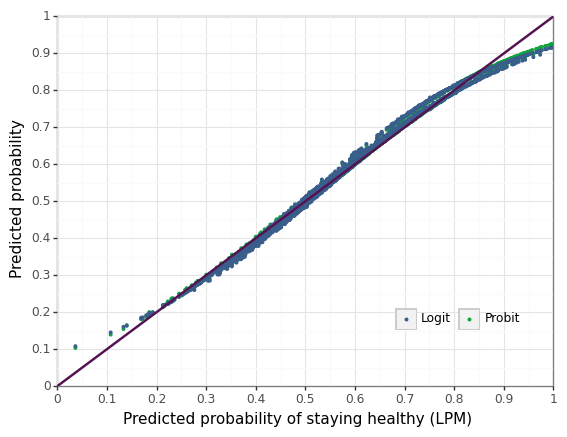

<ggplot: (684764913)>

In [ ]:
g5 = (
    ggplot(df_plot, aes(x="pred_lpm", y="value", color="variable"))
    + geom_point(size=0.6)
    + geom_abline(color=color[2], intercept=0, slope=1, size=1)
    + labs(
        x="Predicted probability of staying healthy (LPM)", y="Predicted probability"
    )
    + scale_y_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=seq(0, 1.1, 0.1))
    + scale_x_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=seq(0, 1.1, 0.1))
    + scale_color_manual(values=[color[0], color[1]])
    + theme_bw()
    + theme(
        legend_title=element_blank(),
        legend_direction="horizontal",
        legend_position=(0.75, 0.25),
        legend_background=element_blank(),
    )
)
g5

# Part 5 goodness of fit

In [ ]:
lpmbase = smf.ols("stayshealthy ~ smoking", data=share).fit()


In [ ]:
share["pred_lpmbase"] = lpmbase.predict()


### Figure 11.7 Staying healthy and the distribution of the predicted probability of staying healthy. Two linear probability model

(a) Simple LPM

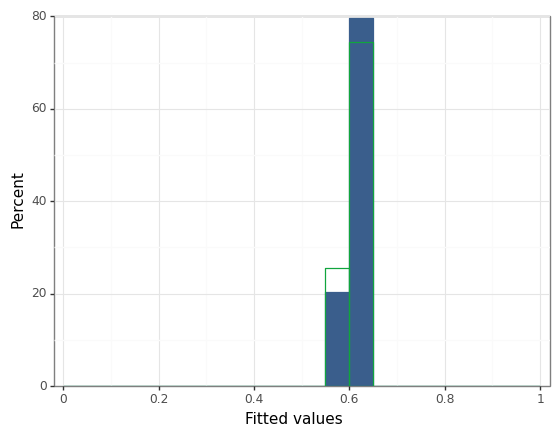

<ggplot: (687084421)>

In [ ]:
(
    ggplot(
        share,
        aes(x="pred_lpmbase", fill="stayshealthy", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        share[share["stayshealthy"] == 1],
        binwidth=0.05,
        color=color[0],
        fill=color[0],
        boundary=0.55,
    )
    + geom_histogram(
        share[share["stayshealthy"] == 0],
        binwidth=0.05,
        color=color[1],
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 80], breaks=seq(0, 81, 20))
    + theme_bw()
)

(b) Rich LPM

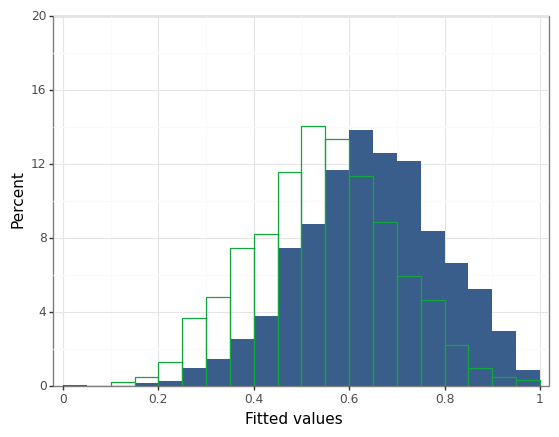

<ggplot: (684763215)>

In [ ]:
g7b = (
    ggplot(
        share,
        aes(x="pred_lpm", fill="stayshealthy", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        share[share["stayshealthy"] == 1],
        binwidth=0.05,
        # color="blue",
        fill=color[0],
        boundary=0.55,
    )
    + geom_histogram(
        share[share["stayshealthy"] == 0],
        binwidth=0.05,
        color=color[1],
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 20], breaks=seq(0, 21, 4))
    + theme_bw()
)
g7b


#### Table 11.4 Comparing probability models – mean and median

In [ ]:
share.groupby("stayshealthy")[
    "pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"
].mean().round(3)


,pred_lpmbase,pred_lpm,pred_logit,pred_probit
stayshealthy,,,,
0.0,0.603,0.543,0.542,0.542
1.0,0.606,0.645,0.646,0.646


In [ ]:
share.groupby("stayshealthy")[
    "pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"
].median().round(3)


,pred_lpmbase,pred_lpm,pred_logit,pred_probit
stayshealthy,,,,
0.0,0.62,0.543,0.544,0.545
1.0,0.62,0.647,0.655,0.653


### Table 11.5 Statistics of goodness of fit for the probability predictions of three models

In [ ]:
pd.DataFrame(
    {
        "R-squared": [
            lpm3.rsquared,
            r2_score(share["stayshealthy"], share["pred_logit"]),
            r2_score(share["stayshealthy"], share["pred_probit"]),
        ],
        "Brier-score": [
            mean_squared_error(share["stayshealthy"], share["pred_lpm"]),
            mean_squared_error(share["stayshealthy"], share["pred_logit"]),
            mean_squared_error(share["stayshealthy"], share["pred_probit"]),
        ],
        "Pseudo R-squared": [np.nan, logit_result.prsquared, probit_result.prsquared],
        "Log-loss": [
            -1 * log_loss(share["stayshealthy"], share["pred_lpm"]),
            -1 * log_loss(share["stayshealthy"], share["pred_logit"]),
            -1 * log_loss(share["stayshealthy"], share["pred_probit"]),
        ],
    },
    index=["LPM", "Logit", "Probit"],
).T.round(3)


,LPM,Logit,Probit
R-squared,0.103,0.104,0.104
Brier-score,0.215,0.214,0.214
Pseudo R-squared,NaN,0.080,0.080
Log-loss,-0.620,-0.617,-0.617


### Figure 11.8 Calibration curves for the predictions of the linear probability and logit models

(a) LPM

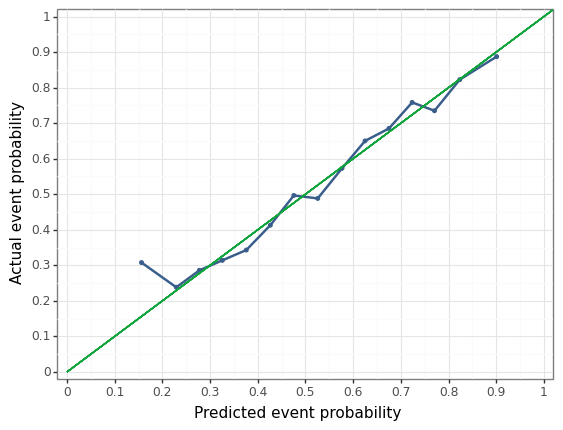

<ggplot: (674625922)>

In [ ]:
create_calibration_plot(
    share,
    file_name="ch11-figure-8b-calib-logit",
    prob_var="pred_lpm",
    actual_var="stayshealthy",
    breaks=np.array(
        [
            0,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            1.05,
        ]
    ),
)


(b) Logit

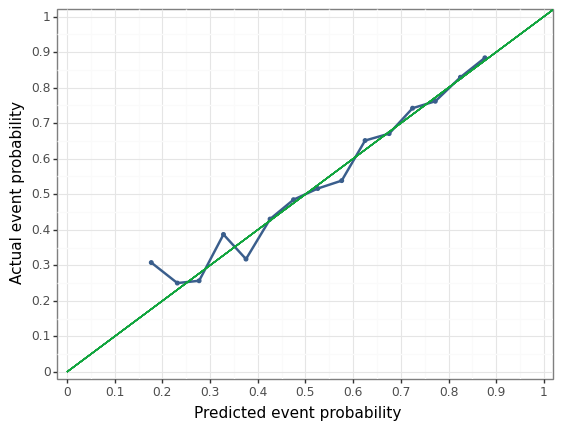

<ggplot: (687277294)>

In [ ]:
create_calibration_plot(
    share,
    file_name="ch11-figure-8b-calib-logit",
    prob_var="pred_logit",
    actual_var="stayshealthy",
    breaks=np.array(
        [
            0,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            1.05,
        ]
    ),
)


In [ ]:
## Part 7


In [ ]:
df = share[["pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"]].copy()


In [ ]:
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i, j] > 0.5:
            df.iloc[i, j] = 1
        else:
            df.iloc[i, j] = 0


In [ ]:
pd.crosstab(df.iloc[:, 0], share["stayshealthy"], normalize="all")


stayshealthy,0.0,1.0
pred_lpmbase,,
1.0,0.395304,0.604696


In [ ]:
for j in range(df.shape[1]):
    print(pd.crosstab(df.iloc[:, j], share["stayshealthy"], normalize="all"))
    print(pd.crosstab(df.iloc[:, j], share["stayshealthy"], normalize="columns"))


stayshealthy       0.0       1.0
pred_lpmbase                    
1.0           0.395304  0.604696
stayshealthy  0.0  1.0
pred_lpmbase          
1.0           1.0  1.0
stayshealthy       0.0       1.0
pred_lpm                        
0.0           0.149244  0.100675
1.0           0.246060  0.504021
stayshealthy       0.0       1.0
pred_lpm                        
0.0           0.377543  0.166489
1.0           0.622457  0.833511
stayshealthy       0.0       1.0
pred_logit                      
0.0           0.153104  0.101962
1.0           0.242200  0.502734
stayshealthy       0.0       1.0
pred_logit                      
0.0           0.387307  0.168617
1.0           0.612693  0.831383
stayshealthy       0.0       1.0
pred_probit                     
0.0           0.150209  0.101640
1.0           0.245095  0.503056
stayshealthy       0.0       1.0
pred_probit                     
0.0           0.379984  0.168085
1.0           0.620016  0.831915


## Figure 11.4 The logit and probit link functions

In [ ]:
share = pd.read_csv(os.path.join(data_out, "ch11_share.csv"))


In [ ]:
share["country"] = share["country"].astype("category")


In [ ]:
y, X = dmatrices(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",
    share,
)


In [ ]:
logit = sm.Logit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [ ]:
logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08031
Time:                        15:48:16   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [ ]:
share["bx_logit"] = np.asarray(X).dot(logit.params)


In [ ]:
share["Logit"] = logistic.cdf(share["bx_logit"])


In [ ]:
probit = sm.Probit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [ ]:
probit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08018
Time:                        15:48:16   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [ ]:
share["bx_probit"] = np.asarray(X).dot(probit.params)


In [ ]:
share["Probit"] = norm.cdf(share["bx_probit"])


In [ ]:
share_plot = pd.melt(
    share[["bx_logit", "Logit", "Probit"]],
    id_vars=["bx_logit"],
    value_vars=["Logit", "Probit"],
)


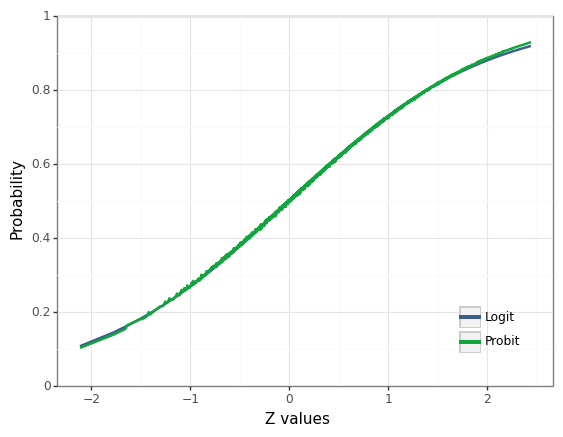

<ggplot: (687368593)>

In [ ]:
g4 = (
    ggplot(data=share_plot)
    + geom_line(aes(x="bx_logit", y="value", color="variable"), size=1)
    + ylab("Probability")
    + xlab("Z values")
    + scale_color_manual(values=color[0:2], name=" ", labels=("Logit", "Probit"))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + theme_bw()
    + theme(
        legend_position=(0.8, 0.25),
        legend_direction="vertical",
        legend_background=element_blank(),
    )
)
g4